In [9]:
import numpy as np
import plotly.graph_objects as go
import scipy
import os
import torch

# loaded directory
# directory = 'outputs/polycam_mate_floor/nerfacto/2023-11-22_200027/wandb/plots'
# directory = 'outputs/polycam_mate_floor/depth-nerfacto/2023-12-09_000432/wandb/plots'
# directory = 'outputs/polycam_sculpture/depth-nerfacto/2023-12-14_011651/wandb/plots'
directory = 'outputs/polycam_doorHandle/depth-nerfacto/2023-12-13_230424/wandb/plots'
# directory = 'outputs/polycam_extinguisher/depth-nerfacto/2023-12-14_222003/wandb/plots'
# directory = 'outputs/polycam_sink/depth-nerfacto/2023-12-15_002309/wandb/plots'
# directory = 'outputs/polycam_ethStore/depth-nerfacto/2023-12-15_012934/wandb/plots'
# directory = 'outputs/polycam_poster/depth-nerfacto/2023-12-15_031707/wandb/plots'
# directory = 'outputs/polycam_speaker/depth-nerfacto/2023-12-16_160054/wandb/plots'
# directory = 'outputs/polycam_candle/depth-nerfacto/2023-12-16_154927/wandb/plots'
# directory = 'plots_sculpture_demo'

In [10]:
# Load the occupancy data from the .npy file
occupancy_grid = np.load(os.path.join(directory, 'object_occupancy.npy'))
# occupancy_grid = np.load(r'G:\Mixed_Reality\mr_liuxin\nerfstudio\object_occupancy.npy')
#G:\Mixed_Reality\cs\object_occupancy.npy
# Get the dimensions of the grid
grid_size = occupancy_grid.shape[0]

# Generate grid coordinates
x, y, z = np.meshgrid(np.linspace(-1, 1, grid_size), 
                      np.linspace(-1, 1, grid_size), 
                      np.linspace(-1, 1, grid_size),
                      indexing='ij')

# Filter coordinates based on occupancy
occupied_x = x[occupancy_grid]
occupied_y = y[occupancy_grid]
occupied_z = z[occupancy_grid]
print(np.min(occupied_x), np.max(occupied_x))
print(np.min(occupied_y), np.max(occupied_y))
print(np.min(occupied_z), np.max(occupied_z))

# dilate the occupancy grid by 1 voxel
occupancy_grid_torch = torch.from_numpy(occupancy_grid)
struct = scipy.ndimage.generate_binary_structure(3, 2)
occupancy_grid_dilated = scipy.ndimage.binary_dilation(occupancy_grid_torch, structure=struct, iterations=1)

# Filter coordinates based on dilated occupancy
occupied_x_dilated = x[occupancy_grid_dilated]
occupied_y_dilated = y[occupancy_grid_dilated]
occupied_z_dilated = z[occupancy_grid_dilated]

# Create a 3D scatter plot
occupancy = go.Scatter3d(x=occupied_x, y=occupied_y, z=occupied_z, mode='markers', marker=dict(size=1, color='blue'))

# Create a 3D scatter plot for dilated occupancy with a different color
occupancy_dilated = go.Scatter3d(x=occupied_x_dilated, y=occupied_y_dilated, z=occupied_z_dilated, mode='markers', marker=dict(size=0.5, color='red'))

# fig = go.Figure(data=[occupancy])
fig = go.Figure(data=[occupancy, occupancy_dilated])

# Update layout
fig.update_layout(
    title="3D Occupancy Grid",
    scene=dict(
        xaxis=dict(nticks=4, range=[-1, 1]),
        yaxis=dict(nticks=4, range=[-1, 1]),
        zaxis=dict(nticks=4, range=[-1, 1]),
        aspectratio=dict(x=1, y=1, z=1)
    )
)

# Show plot
fig.show()


-0.6535433070866141 -0.3858267716535433
-0.35433070866141736 -0.03937007874015752
-0.10236220472440949 0.023622047244094446


In [11]:
# Points for plane fitting
points = np.load(os.path.join(directory, 'plane_samples.npy'))
# points = np.load(r'G:\Mixed_Reality\mr_liuxin\nerfstudio\plane_samples.npy')


# Plane equation coefficients
coeffs = np.load(os.path.join(directory, 'plane_coefficients.npy'))
# coeffs = np.load(r'G:\Mixed_Reality\mr_liuxin\nerfstudio\plane_coefficients.npy')
a, b, c, d = coeffs
print(f"plane equation: {a}x + {b}y + {c}z + {d} = 0")

# Bounding box vertices
# bbox_vertices = np.array([
#     [ 0.0114, -0.1916, -0.0216], [-0.5252, -0.1620, -0.3944],
#     [ 0.2723, -0.1808, -0.3962], [-0.2642, -0.1512, -0.7690],
#     [ 0.0221, 0.2614, -0.0010], [-0.5144, 0.2910, -0.3738],
#     [ 0.2830, 0.2722, -0.3756], [-0.2535, 0.3019, -0.7485]
# ])

# Load the AABB from the .npy file
aabb = np.load(os.path.join(directory, 'aabb.npy'))
# aabb = np.load(r'G:\Mixed_Reality\mr_liuxin\nerfstudio\aabb.npy')
min_corner = aabb[0]
max_corner = aabb[1]
# Compute the vertices of the AABB
vertices = np.array([
    [min_corner[0], min_corner[1], min_corner[2]],
    [max_corner[0], min_corner[1], min_corner[2]],
    [max_corner[0], max_corner[1], min_corner[2]],
    [min_corner[0], max_corner[1], min_corner[2]],
    [min_corner[0], min_corner[1], max_corner[2]],
    [max_corner[0], min_corner[1], max_corner[2]],
    [max_corner[0], max_corner[1], max_corner[2]],
    [min_corner[0], max_corner[1], max_corner[2]],
])
print(f"vertices of the AABB: {vertices}")

# Define the edges of the AABB
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0],  # bottom edges
    [4, 5], [5, 6], [6, 7], [7, 4],  # top edges
    [0, 4], [1, 5], [2, 6], [3, 7],  # side edges
]

# Plot the edges
edge_traces = [
    go.Scatter3d(
        x=[vertices[pair[0], 0], vertices[pair[1], 0]],
        y=[vertices[pair[0], 1], vertices[pair[1], 1]],
        z=[vertices[pair[0], 2], vertices[pair[1], 2]],
        mode='lines',
        line=dict(color='blue', width=2)
    ) for pair in edges
]

# Create a grid for the plane
xx, yy = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
zz = (-a * xx - b * yy - d) / c

x_values = []
y_values = []
z_values = []
offset = 0
# print(points)

""" for point in points:
    if offset % 200 == 0:
        x_values.append(point[0])
        y_values.append(point[1])
        z_values.append(point[2])
    offset += 1

scatter = go.Scatter3d(x=x_values, y=y_values, z=z_values, mode='markers', marker=dict(size=5)) """

# read "sample_colors.npy"
rgb = np.load(os.path.join(directory, 'sample_colors.npy')) # (N, 3)
# find the median of each column
median = np.median(rgb, axis=0) # (3,)
# find the covariance matrix of the rgb values
cov = np.cov(rgb.T) # (3, 3)
# inverse of the covariance matrix
cov_inv = np.linalg.inv(cov) # (3, 3)
# find the mahalanobis distance of each point from the median
mahalanobis = scipy.spatial.distance.cdist(rgb, [median], metric='mahalanobis', VI=cov_inv) # (N, 1)
mahalanobis_similarity = 1 / (1 + mahalanobis) # (N, 1)

# points = points[mahalanobis_similarity[:, 0] > 0.6]
# print(f"The number of points after color filtering is {len(points)}")

scatter = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=rgb))

# Plot plane
plane = go.Surface(x=xx, y=yy, z=zz, opacity=0.5)

# Plot bounding box
# bbox_edges = [
#     go.Scatter3d(x=bbox_vertices[[i, j], 0], y=bbox_vertices[[i, j], 1], z=bbox_vertices[[i, j], 2], mode='lines', line=dict(color='red'))
#     for i in range(len(bbox_vertices)) for j in range(i+1, len(bbox_vertices))
# ]

# plot aabb_intersections
aabb_intersections = np.load(os.path.join(directory, 'aabb_intersections.npy'))
intersections_scatter = go.Scatter3d(x=aabb_intersections[:,0], y=aabb_intersections[:,1], z=aabb_intersections[:,2], mode='markers', marker=dict(size=3, color='red'))


# # Combine all plots
# fig = go.Figure(data=[scatter, plane, occupancy] + edge_traces)
# fig = go.Figure(data=[plane, occupancy] + edge_traces)
# fig = go.Figure(data=[scatter, plane, occupancy, intersections_scatter] + edge_traces)
fig = go.Figure(data=[plane, occupancy, intersections_scatter] + edge_traces)
# fig = go.Figure(data=[scatter, occupancy] + edge_traces)
# fig = go.Figure(data=[scatter, plane, occupancy])

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1]),
        yaxis=dict(nticks=4, range=[-1,1]),
        zaxis=dict(nticks=4, range=[-1,1]),
        # xaxis=dict(nticks=4),
        # yaxis=dict(nticks=4),
        # zaxis=dict(nticks=4),
        aspectratio=dict(x=1, y=1, z=1)
    )
)

# Show plot
fig.show()


plane equation: -1.5152691982167523x + -0.39693637452731095y + -0.060086349867800835z + -1.0 = 0
vertices of the AABB: [[-0.65625  -0.359375 -0.109375]
 [-0.390625 -0.359375 -0.109375]
 [-0.390625 -0.046875 -0.109375]
 [-0.65625  -0.046875 -0.109375]
 [-0.65625  -0.359375  0.015625]
 [-0.390625 -0.359375  0.015625]
 [-0.390625 -0.046875  0.015625]
 [-0.65625  -0.046875  0.015625]]


In [12]:
# # read "sample_colors.npy"
# rgb = np.load('sample_colors.npy') # (N, 3)

# # find the median of each column
# median = np.median(rgb, axis=0) # (3,)
# # find the covariance matrix of the rgb values
# cov = np.cov(rgb.T) # (3, 3)
# # inverse of the covariance matrix
# cov_inv = np.linalg.inv(cov) # (3, 3)
# # find the mahalanobis distance of each point from the median
# mahalanobis = scipy.spatial.distance.cdist(rgb, [median], metric='mahalanobis', VI=cov_inv) # (N, 1)
# mahalanobis_similarity = 1 / (1 + mahalanobis) # (N, 1)

# plot the rgb values of all N points, while making the color of each point the corresponding rgb value
table_rgb_scatter = go.Scatter3d(x=rgb[:,0], y=rgb[:,1], z=rgb[:,2], mode='markers', marker=dict(size=2, color=rgb))

# plot the median rgb value as a red point
median_rgb_scatter = go.Scatter3d(x=[median[0]], y=[median[1]], z=[median[2]], mode='markers', marker=dict(size=5, color='red'))

# plot the sample points with real colors
scatter_colored = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=5, color=rgb))

# show the plot
table_rgb_fig = go.Figure(data=[table_rgb_scatter, median_rgb_scatter])
# table_rgb_fig = go.Figure(data=[table_rgb_scatter])

# set axis labels as R, G, B, and axis ranges as [0, 1]
table_rgb_fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[0,1]),
        yaxis=dict(nticks=4, range=[0,1]),
        zaxis=dict(nticks=4, range=[0,1]),
        aspectratio=dict(x=1, y=1, z=1)
    )
)


table_rgb_fig.show()


In [13]:
import torch
from nerfstudio.data.scene_box import OrientedBox

def initialize_grid(resolution, aabb):
    # Initialize a 3D grid with the specified resolution and bounding box
    origin = aabb[0]
    voxel_size = (aabb[1] - aabb[0]) / resolution
    xdim = torch.arange(resolution)
    ydim = torch.arange(resolution)
    zdim = torch.arange(resolution)
    grid = torch.stack(torch.meshgrid([xdim, ydim, zdim], indexing="ij"), dim=0)
    voxel_coords = origin.view(3, 1, 1, 1) + grid * voxel_size.view(3, 1, 1, 1)
    return voxel_coords

voxel_coords = initialize_grid(128, torch.tensor([[-1., -1., -1.], [ 1.,  1.,  1.]]))
occupied_coordinates = voxel_coords[:, occupancy_grid]

print(f"plane_coefficients: {coeffs}")
a, b, c, d = tuple(coeffs)
normal = torch.tensor([a, b, c])
normalized_normal = normal / torch.linalg.norm(normal)
# change normalized_normal to Float
normalized_normal = normalized_normal.type(torch.FloatTensor)
# make sure the z component of the normal is positive
if normalized_normal[2] < 0:
    normalized_normal = -normalized_normal
# convert all occupied_coordinates to a new coordinate system where the z-axis is the normal of the plane, and the xy-plane is the plane specified by the plane coefficients ax + by + cz + d = 0
# Then, by finding the min and max points of the new occupied_coordinates, and clamping the z component to be above 1, we can get the above-table bbox
# First, find the rotation matrix that rotates the z-axis to the normal of the plane
v = torch.cross(torch.tensor([0., 0., 1.]), normalized_normal)
c = torch.dot(torch.tensor([0., 0., 1.]), normalized_normal)
s = v.norm()
kmat = torch.tensor([[0, -v[2], v[1]],
                    [v[2], 0, -v[0]],
                    [-v[1], v[0], 0]])
R = torch.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))
# Then, find the translation vector that translates the origin to the plane
T = -d * normalized_normal
# Then, find the scale vector that scales the z-axis to the distance between the origin and the plane
S = torch.tensor([1, 1, torch.linalg.norm(T)])
# Then, find the new occupied_coordinates
occupied_coordinates_tablealigned = torch.matmul(R, occupied_coordinates) + T.view(3, 1)
# get the min and max points of the new occupied_coordinates
min_point_tablealigned = torch.min(occupied_coordinates_tablealigned, dim=1)[0]
max_point_tablealigned = torch.max(occupied_coordinates_tablealigned, dim=1)[0]
# clamp the z component to be above 0
min_point_tablealigned[2] = torch.max(min_point_tablealigned[2], torch.tensor(0.))
max_point_tablealigned[2] = torch.max(max_point_tablealigned[2], torch.tensor(0.))
# get the above-table bbox as a OrientedBox object
obb_R = R
obb_S = max_point_tablealigned - min_point_tablealigned
obb_T = T
obb = OrientedBox(obb_R, obb_S, obb_T)

# Using obb.within(occupied_coordinates), we can get a mask of all the points that are within the obb
# Then, we can use this mask to filter the points
# First, get the mask
mask = obb.within(occupied_coordinates.T)
# Then, filter the points
occupied_coordinates_filtered = occupied_coordinates[:, mask]
# Then, plot the filtered points
# scatter_filtered = go.Scatter3d(x=occupied_coordinates_filtered[0], y=occupied_coordinates_filtered[1], z=occupied_coordinates_filtered[2], mode='markers', marker=dict(size=1))
scatter_filtered = go.Scatter3d(x=occupied_coordinates[0], y=occupied_coordinates[1], z=occupied_coordinates[2], mode='markers', marker=dict(size=1))


fig_filtered = go.Figure(data=[scatter_filtered])
fig_filtered.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1]),
        yaxis=dict(nticks=4, range=[-1,1]),
        zaxis=dict(nticks=4, range=[-1,1]),
        aspectratio=dict(x=1, y=1, z=1)
    )
)
fig_filtered.show()





plane_coefficients: [-1.5152692  -0.39693637 -0.06008635 -1.        ]


/srv/beegfs02/scratch/data_shichen/data/nerfstudio/nerfstudio/data/scene_box.py:133: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/srv/beegfs02/scratch/data_shichen/data/nerfstudio/nerfstudio/data/scene_box.py:134: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[[-0.09375    -0.203125   -0.84019756]
 [-0.09375    -0.0625     -0.84424245]
 [ 0.0625     -0.203125   -0.8420728 ]
 [ 0.0625     -0.0625     -0.8461176 ]]
348.0 1411.0


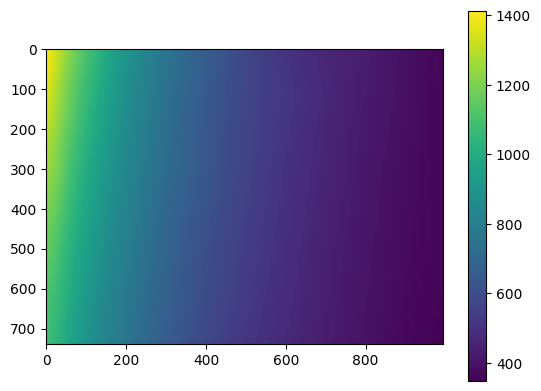

In [14]:
from PIL import Image
import numpy as np

# read "data/nerfstudio/polycam_mate_floor_hack/inpainted/depth_inpaint/frame00001.png" from png file as a numpy array
# inpainted_depth_path = 'data/nerfstudio/polycam_mate_floor_hack/inpainted/depth_inpaint/frame00001.png'
# inpainted_depth_path = 'outputs/polycam_mate_floor/nerfacto/2023-11-22_200027/eval_images/frame_00001_depth.png'
real_depth_path = 'data/nerfstudio/polycam_mate_floor/depth/frame_00001.png'

nsa_intersection_path = 'outputs/polycam_mate_floor/depth-nerfacto/2023-12-09_000432/wandb/plots/aabb_intersections.npy'
nsa_intersection = np.load(nsa_intersection_path)
print(nsa_intersection)

# inpainted_depth = np.array(Image.open(inpainted_depth_path))
real_depth = np.array(Image.open(real_depth_path))

# for the region 300<x<500, 250<y<400, do linear interpolation
x_lower, x_upper = 300, 500
y_lower, y_upper = 250, 400
upper_border = real_depth[y_lower, x_lower:x_upper] # (200,)
lower_border = real_depth[y_upper, x_lower:x_upper] # (200,)
left_border = real_depth[y_lower:y_upper, x_lower].reshape([-1, 1]) # (150, 1)
right_border = real_depth[y_lower:y_upper, x_upper].reshape([-1, 1]) # (150, 1)

interpolated_depth = real_depth.copy()
x_unit_linspace = np.linspace(0, 1, x_upper - x_lower) # (200,)
y_unit_linspace = np.linspace(0, 1, y_upper - y_lower).reshape([-1, 1]) # (150,1)
x_difference = right_border - left_border # (150, 1)
y_difference = lower_border - upper_border # (200,)
# linear interpolation on the x-direction
x_inpainting = x_difference * x_unit_linspace + left_border # (150, 200)
# linear interpolation on the y-direction
y_inpainting = y_difference * y_unit_linspace + upper_border # (150, 200)

interpolated_depth_x = interpolated_depth.copy()
interpolated_depth_x[y_lower:y_upper, x_lower:x_upper] = x_inpainting
interpolated_depth_y = interpolated_depth.copy()
interpolated_depth_y[y_lower:y_upper, x_lower:x_upper] = y_inpainting

interpolation_diff = interpolated_depth_x - interpolated_depth_y
interpolated_depth_average = (interpolated_depth_x + interpolated_depth_y) / 2

# save interpolated_depth_average as 16-bit png
# check if the depth values are within the range of 0-65535
print(np.min(interpolated_depth_average), np.max(interpolated_depth_average))
assert np.min(interpolated_depth_average) >= 0 and np.max(interpolated_depth_average) <= 65535
interpolated_depth_average = interpolated_depth_average.astype(np.uint16)
# save the depth map as a png file
interpolated_depth_average_path = 'interpolated_depth_average.png'
interpolated_depth_average_image = Image.fromarray(interpolated_depth_average)
interpolated_depth_average_image.save(interpolated_depth_average_path)


# draw a histogram of the depth values
import matplotlib.pyplot as plt
# plt.hist(inpainted_depth.flatten(), bins=100)
# plt.show()



# visualize the depth map in 2D
# import matplotlib.pyplot as plt
# plt.imshow(inpainted_depth)
# plt.imshow(real_depth)
# plt.imshow(interpolated_depth_x)
# plt.imshow(interpolated_depth_y)
# plt.imshow(interpolation_diff)
plt.imshow(interpolated_depth_average)
# plt.imshow(interpolated_depth_average - interpolated_depth_x)
plt.colorbar()
plt.show()




In [15]:
# Load camera_poses from 'c2w.npy', which is a Nx3x4 numpy array representing N extrinsic matrices
camera_poses = np.load('c2w_rubbishBin.npy')
# camera_poses = np.load('c2w_mate_floor.npy')

# Extract camera positions (translation vectors) from the extrinsic matrices
camera_positions = camera_poses[:, :3, 3]

# Extract camera orientations (rotation matrices) from the extrinsic matrices
camera_orientations = camera_poses[:, :3, :3]

# Compute the direction of each camera (assuming they are looking along the z-axis)
camera_directions = np.einsum('ijk,ik->ij', camera_orientations, np.array([[0, 0, 1]]))


fig = go.Figure(data=[go.Scatter3d(
    x=camera_positions[:, 0],
    y=camera_positions[:, 1],
    z=camera_positions[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=camera_positions[:, 2],  # color by z-coordinate for example
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Draw lines indicating the orientation of the camera
for i in range(len(camera_positions)):
    fig.add_trace(go.Scatter3d(
        x=[camera_positions[i, 0], camera_positions[i, 0] + camera_directions[i, 0]],
        y=[camera_positions[i, 1], camera_positions[i, 1] + camera_directions[i, 1]],
        z=[camera_positions[i, 2], camera_positions[i, 2] + camera_directions[i, 2]],
        mode='lines',
        line=dict(
            color='red',
            width=2
        )
    ))

fig.show()